In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import utils
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestClassifier
from RandomForest import RandomForestClassifierImpl

Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

In [99]:
max = 7
precision = .1

def create_grid():
  return np.mgrid[-max:max:precision, -max:max:precision]

In [100]:
# Распределение 1
_dist1_comp_1 = multivariate_normal([-2,2], [[7, 0], [-1, 2]])
_dist1_comp_2 = multivariate_normal([2,1], [[4, 1], [1, 2]])

def prob_1(pos):
  return _dist1_comp_1.pdf(pos) + _dist1_comp_2.pdf(pos)

In [101]:
# Распределение 2
_dist2_comp_1 = multivariate_normal([3,0], [[2, 1], [1, 2]])
_dist2_comp_2 = multivariate_normal([0,-2], [[4, 1], [1, 2]])
_dist2_comp_3 = multivariate_normal([-1,-1], [[4, 1], [1, 2]])

def prob_2(pos):
  return _dist2_comp_1.pdf(pos) + _dist2_comp_2.pdf(pos) + _dist2_comp_3.pdf(pos)

In [102]:
x, y = create_grid()
pos = np.dstack((x, y))

In [103]:
maxProb1 = np.max(prob_1(pos))
maxProb2 = np.max(prob_2(pos))

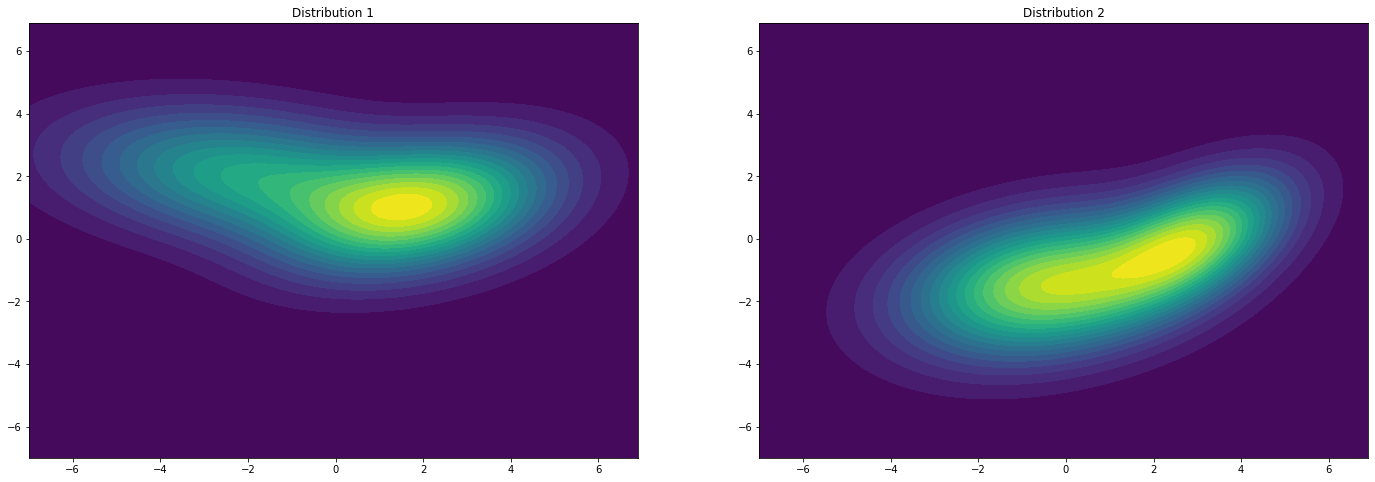

In [104]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Distribution 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)

ax2 = fig.add_subplot(122)
ax2.set_title('Distribution 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)

plt.show()

Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.

In [105]:
def generate_samples(prob, max_prob, size, target):
  samples = []
  while len(samples) != size:
    randCoords = np.random.uniform(-max, max, 2)
    randProb = np.random.uniform(0.0, 1.0, 1)[0]
    sample_prob = prob([randCoords[0], randCoords[1]])
    if (sample_prob / max_prob > randProb):
      samples.append([target, randCoords[0], randCoords[1]])
  return np.array(samples)

def generate_dataset(size, verbose = False):
  size1 = round(np.random.normal(size / 2, 7, 1)[0])
  if size1 <= 0 or size1 > size:
    size1 = round(size / 2)

  samples1 = generate_samples(prob_1, maxProb1, size1, 1)
  samples2 = generate_samples(prob_2, maxProb2, size - size1, 2)

  if verbose:
    print(f"Created samples: {size}")
    print(f"Samples ratio: {size1}/{size - size1}")

  dataset = np.concatenate([samples1, samples2])
  return utils.shuffle(dataset)

In [106]:
dataset = generate_dataset(100, verbose=True)

Created samples: 100
Samples ratio: 55/45


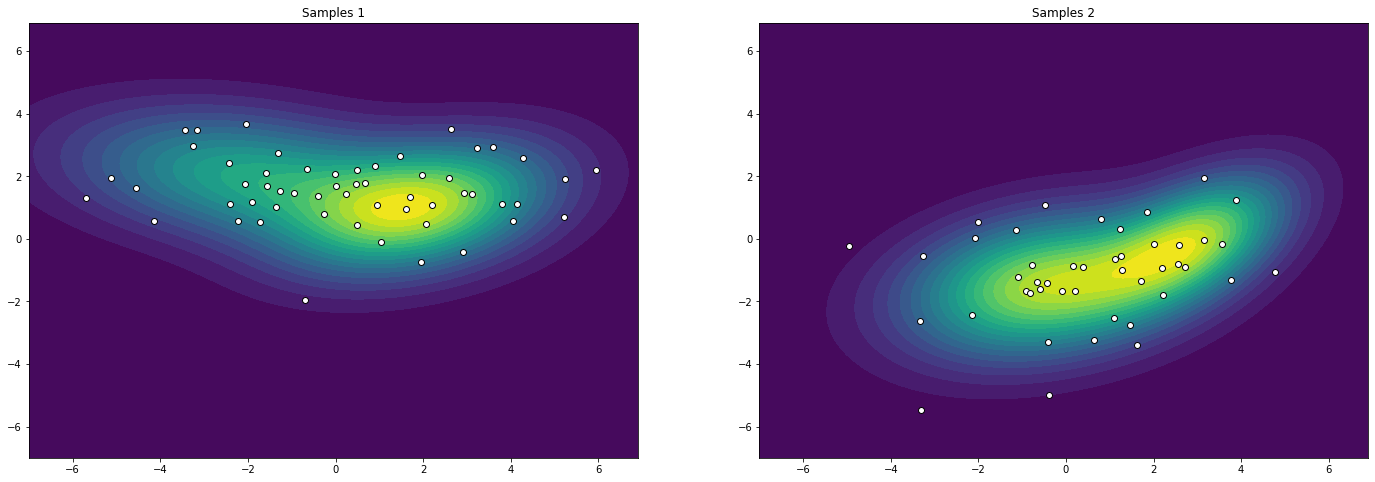

In [107]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Samples 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)
ax.scatter(dataset[dataset[:, 0] == 1, 1], dataset[dataset[:, 0] == 1, 2], c='white', edgecolors='black')

ax2 = fig.add_subplot(122)
ax2.set_title('Samples 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)
ax2.scatter(dataset[dataset[:, 0] == 2, 1], dataset[dataset[:, 0] == 2, 2], c='white', edgecolors='black')

plt.show()

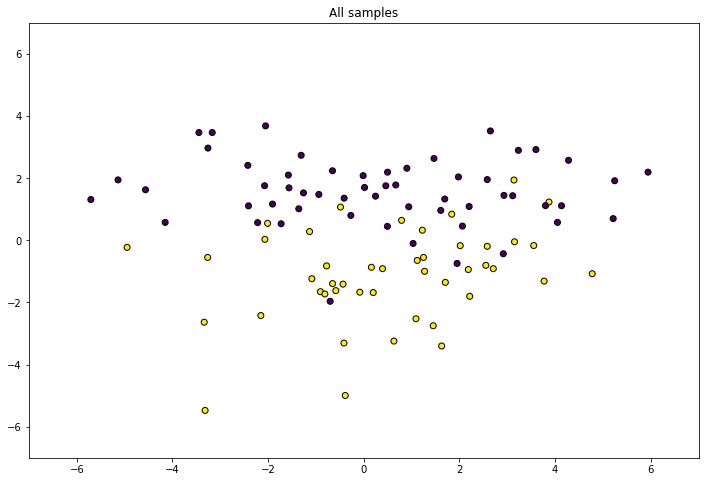

In [108]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_title('All samples')
ax.set_xlim(-max, max)
ax.set_ylim(-max, max)
ax.scatter(dataset[:,1],dataset[:,2], c=dataset[:,0], edgecolors='black');

In [109]:
def draw_predictions_on_decision_plane(clf, ax, dataset, decision_grid):
    ax.set_xlim(-max, max)
    ax.set_ylim(-max, max)
    cs = ax.contourf(x, y, decision_grid , levels=1)
    ax.scatter(dataset[:,1],dataset[:,2], c=dataset[:,0], edgecolors='black');
    predictions = clf.predict(dataset[:, 1:])
    ax.scatter(dataset[dataset[:, 0] != predictions, 1], 
            dataset[dataset[:, 0] != predictions, 2], c='red', marker='x')


def decision_plane_test(clf, train_dataset, test_dataset):
    clf.fit(train_dataset[:, 1:], train_dataset[:, 0])
    decision_grid = clf.predict(pos.reshape(pos.shape[0]**2, 2))
    decision_grid = decision_grid.reshape(pos.shape[0],pos.shape[1])

    fig = plt.figure(figsize=(24, 8))

    train_sub_plot = fig.add_subplot(121)
    train_sub_plot.set_title(f'Prediction result on the decision plane | Train score: {clf.score(train_dataset[:, 1:], train_dataset[:, 0])}')
    draw_predictions_on_decision_plane(clf, train_sub_plot, train_dataset, decision_grid)
    
    test_sub_plot = fig.add_subplot(122)
    test_sub_plot.set_title(f'Prediction result on the decision plane | Test score: {clf.score(test_dataset[:, 1:], test_dataset[:, 0])}')
    draw_predictions_on_decision_plane(clf, test_sub_plot, test_dataset, decision_grid)

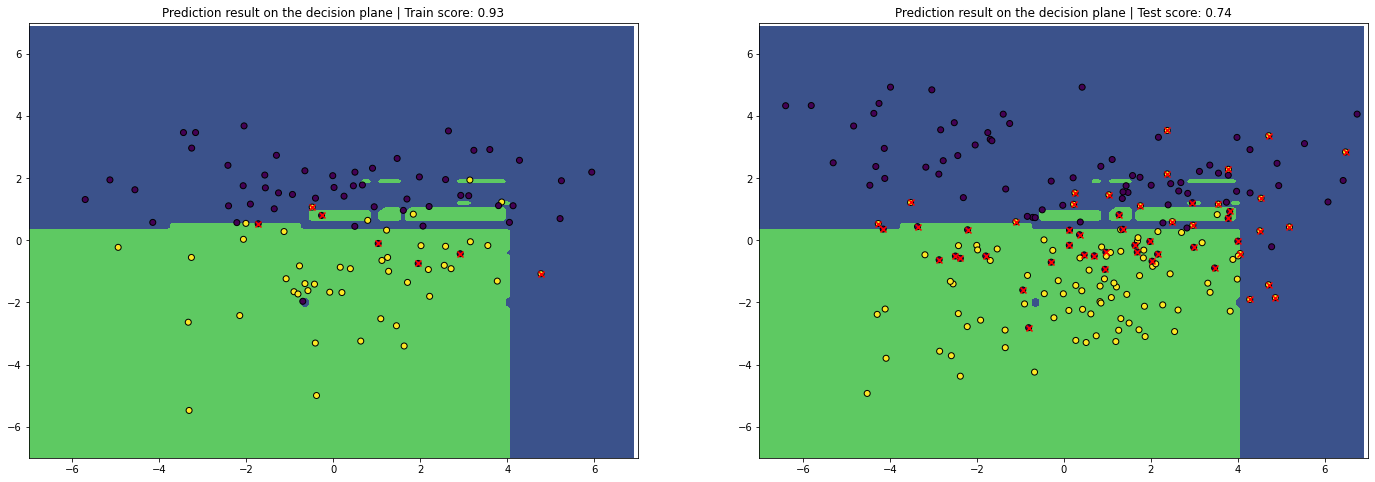

In [110]:
test_dataset = generate_dataset(200)
clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=0)
decision_plane_test(clf, dataset, test_dataset)

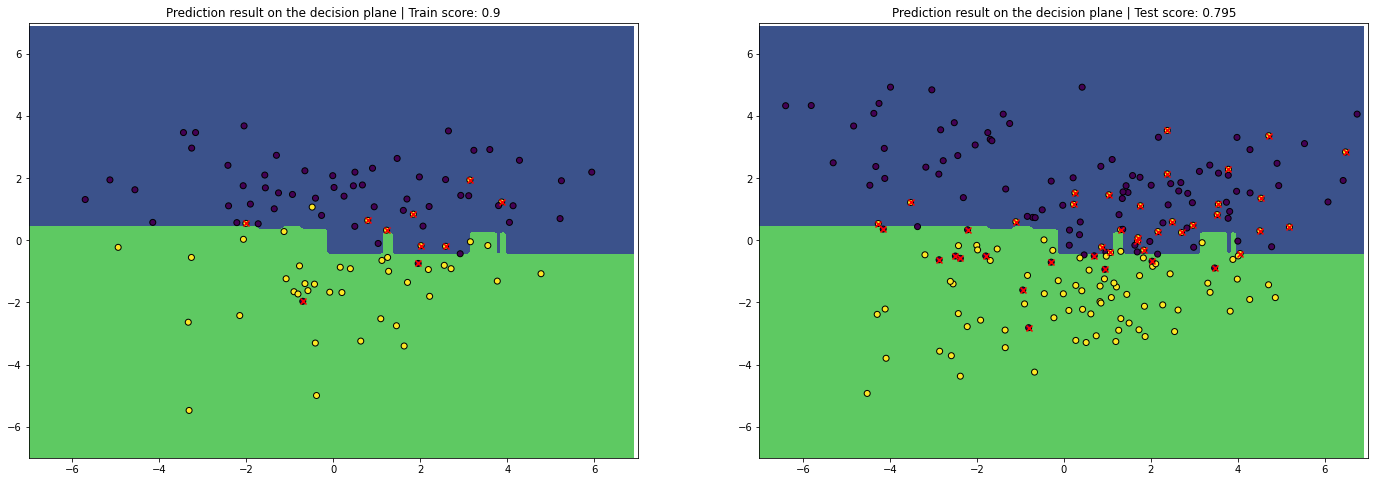

In [111]:
clf = RandomForestClassifierImpl(n_estimators=5, max_depth=5, random_state=0)
decision_plane_test(clf, dataset, test_dataset)

In [112]:
def RandomForestClassifierGetter(n_estimators, max_depth):
    def GetModel():
        return  RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    return GetModel

In [113]:
def score_test(clf_getter, repeats):
  results = []
  for i in range(repeats):
    clf = clf_getter()
    print(f'Test {i}/{repeats}')
    result = []

    train_dataset = generate_dataset(100)
    X = train_dataset[:, 1:]
    y = train_dataset[:, 0]

    clf.fit(X, y)
    result.append(1 - clf.score(X, y))
    
    clf = clf_getter()
    scores_cv = []
    kFolds = KFold(n_splits=5, shuffle=False)
    for train_index, test_index in kFolds.split(y):
      X_train = np.take(X, train_index, axis=0)
      X_test = np.take(X, test_index, axis=0)
      y_train = np.take(y, train_index)
      y_test = np.take(y, test_index)
      clf.fit(X_train, y_train)
      scores_cv.append(1 - clf.score(X_test, y_test))
    result.append(np.mean(scores_cv))

    test_dataset = generate_dataset(1000)
    X = test_dataset[:, 1:]
    y = test_dataset[:, 0]
    result.append(1 - clf.score(X, y))

    results.append(result)
  
  df = pd.DataFrame(results)
  df.columns = ['Эмпирический риск','Скользящий экзамен','Контрольная выборка']
  return df

In [114]:
results = score_test(RandomForestClassifierGetter(10, 5), 5)
results

Test 0/5
Test 1/5
Test 2/5
Test 3/5
Test 4/5


,Эмпирический риск,Скользящий экзамен,Контрольная выборка
0,0.06,0.20,0.225
1,0.03,0.11,0.234
2,0.07,0.27,0.254
3,0.06,0.21,0.238
4,0.08,0.22,0.238


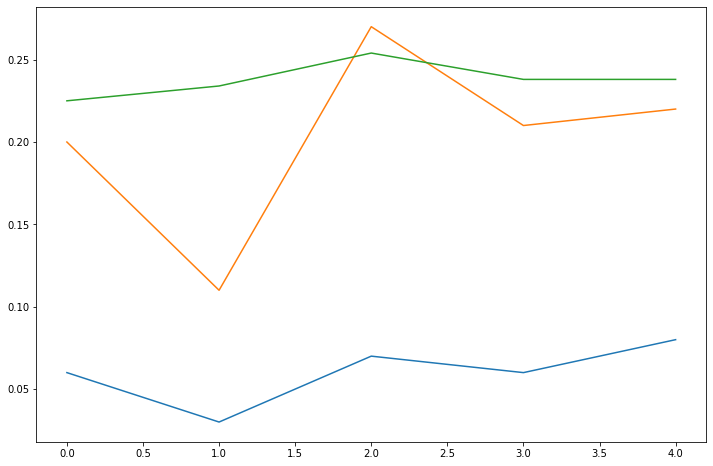

In [115]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot(results["Эмпирический риск"])
ax.plot(results["Скользящий экзамен"])
ax.plot(results["Контрольная выборка"]);